In [591]:
#E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training,
# the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need 
# to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta
# into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward 
# pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [592]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [593]:
def encoders(f):
    words = f.read().splitlines()
    names = ''.join(words)
    vocab = sorted(list(set(names)))
    vocab = ['.'] + vocab
    vocab_size = len(vocab)
    stoi = {c: i for i, c in enumerate(vocab)}
    itos = {c: i for i, c in stoi.items()}

    return vocab, vocab_size, stoi, itos, words

def process(words,stoi):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0]*block_size
        for c in w+ '.':
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

def data():
    with open('names.txt', 'r') as f:
        vocab, vocab_size, stoi, itos, words = encoders(f)
        n1 = int(len(words)*0.8)
        n2 = int(len(words)*0.9)
        xtrain, ytrain = process(words[:n1],stoi)
        xtest, ytest = process(words[n1:n2],stoi)
        xval, yval = process(words[n2:],stoi)

        print(f"xtrain and ytrain shape: {xtrain.shape}, {ytrain.shape}")
        print(f"xtest and ytest shape: {xtest.shape}, {ytest.shape}")
        print(f"xval and yval shape: {xval.shape}, {yval.shape}")
        return xtrain, ytrain, xtest, ytest, xval, yval, vocab_size, stoi, itos

In [594]:
xtrain, ytrain, xtest, ytest, xval, yval, vocab_size, stoi, itos = data()

xtrain and ytrain shape: torch.Size([182778, 3]), torch.Size([182778])
xtest and ytest shape: torch.Size([22633, 3]), torch.Size([22633])
xval and yval shape: torch.Size([22735, 3]), torch.Size([22735])


In [595]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.W = torch.randn(fan_in, fan_out ) / fan_in**0.5
        self.b = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.W
        if self.b != None:
            return self.out + self.b
        else:
            return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b == None else [self.b])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self,x, training):
        if training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, unbiased=True, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat =  (x - xmean) / torch.sqrt((xvar + self.eps))
        self.out = xhat * self.gamma + self.beta

        # update buffers
        if training:
            self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_emb = 10
n_hidden = 100

C = torch.randn(vocab_size, n_emb)
layers = [Linear(n_emb*3, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
          Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
          ]

with torch.no_grad():
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

parameters = [param for layer in layers for param in layer.parameters()]
print(f"Number of parameters: {sum(param.nelement() for param in parameters)}")
for p in parameters:
    p.requires_grad = True

Number of parameters: 16381


In [596]:
max_steps = 16000
batch_size = 32
lossi = []
stepi = []

for i in range(max_steps):
    ix = torch.randint(0, xtrain.shape[0], (batch_size,))
    xb, yb = xtrain[ix], ytrain[ix]

    emb = C[xb]
    x = emb.view(-1, xtrain.shape[1]*n_emb) # n, n_emb*block_size

    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            x = layer(x, training=True)
        else:
            x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    lossi.append(loss.log10().item())

    lr = 0.1 if i < max_steps/2 else 0.01
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
    if i % (max_steps//5) == 0:
        print(f"Step {i}, Loss {loss.item()}")
    

Step 0, Loss 3.2787222862243652
Step 3200, Loss 1.9612680673599243
Step 6400, Loss 2.0972514152526855
Step 9600, Loss 2.4062533378601074
Step 12800, Loss 2.0870463848114014


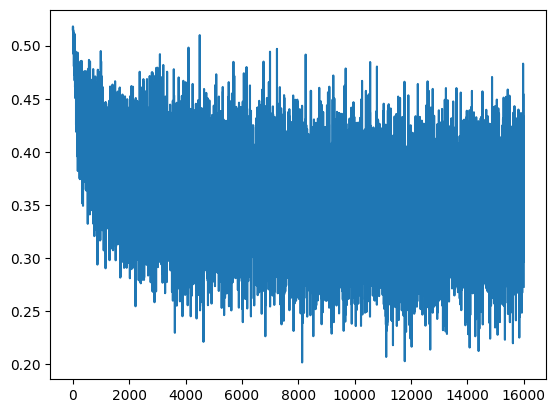

In [597]:
plt.plot(lossi)

# Folding

Let $$z = xW + b$$ and $$y = \gamma * \frac{(z-\mu)}{\sqrt{\sigma + \epsilon}} + \beta$$ Where z is the output of some linear layer, and y the batch normalisation of z. We want to find W2 and b2 so that we can make both operations converge into a single one.
Lets start substituting z in y: $$y = \gamma * \frac{(xW+b-\mu)}{\sqrt{\sigma + \epsilon}} + \beta = \frac{\gamma}{\sqrt{\sigma + \epsilon}} xW + [\frac{\gamma}{\sqrt{\sigma + \epsilon}} b - \frac{\gamma \mu}{\sqrt{\sigma + \epsilon}} + \beta ]$$

Let $$W2 = W\frac{\gamma}{\sqrt{\sigma + \epsilon}}$$ and $$b2 = [\frac{\gamma}{\sqrt{\sigma + \epsilon}} b - \frac{\gamma \mu}{\sqrt{\sigma + \epsilon}} + \beta ]$$ or cleaner: $$b2 = (\frac{\gamma}{\sqrt{\sigma + \epsilon}}) (b-\mu) + \beta$$

In [598]:
example = torch.randn((32, 3), dtype=torch.float32)

In [599]:
# normal inference
with torch.no_grad():
    emb = C[example.long()]
    x1 = emb.view(-1, xtrain.shape[1]*n_emb) # n, n_emb*block_size
    x3 = emb.view(-1, xtrain.shape[1]*n_emb) # n, n_emb*block_size
    for i,layer in enumerate(layers):
            if isinstance(layer, BatchNorm1d):
                x1 = layer(x1, training=False)
                
            else:
                x1 = layer(x1)

In [600]:
# fold batchnorm into linear
for i,layer in enumerate(layers):
    if isinstance(layer, Linear):
        layer.W = layer.W * (layers[i+1].gamma)/torch.sqrt(layers[i+1].running_var + 1e-5) 
        layer.b = ((layers[i+1].gamma)* (layer.b -layers[i+1].running_mean))/torch.sqrt(layers[i+1].running_var + 1e-5) + layers[i+1].beta

# inference
with torch.no_grad():
    emb = C[example.long()]
    x2 = emb.view(-1, xtrain.shape[1]*n_emb) # n, n_emb*block_size

    for i,layer in enumerate(layers):
        # skiping batchnorm
        if isinstance(layer, BatchNorm1d):
            continue
        else:
            x2 = layer(x2)

In [601]:
# check if the output is the same
print(torch.allclose(x1, x2, atol=1e-4))

True
